In [30]:
install.packages("glmnet")


The downloaded binary packages are in
	/var/folders/81/prx5h13144gcc7v9m0gcd3c80000gn/T//RtmpgMXeEr/downloaded_packages


In [31]:
library("glmnet")

In [32]:
# Creating synthetic data

In [33]:
#Our population
set.seed(24) #This function allows to use randomly generated numbers, which remain consistent througout our usage. 
N<-100000 #Number of elements in the population
d<-c(rnorm(N,100,10))#d indicates our treatment
x_1<-c(1:N) #x_1 is a covariate
x_2<-runif(N,20,40)+17*d #x_2 is a covariat, which is strongly correlated with d
y<-d+x_1+0.01*x_2+rnorm(N,1,0.8) #This is the true relationship


In [34]:
#Our population is characterized by further explaining variables
x_3<-c(5+runif(N,20,40)+7.3^0.47)
x_4<-c(x_2*rexp(N,7))
x_5<-c(rnorm(N,14,3))
x_6<-c(rgamma(N,3)+17)
x_7<-c(5+rweibull(N,4,1))
x_8<-c(rnorm(N,73,17)+rgamma(N,6))
x_9<-c(rweibull(N,0.4,0.8))
x_10<-c(0.05*d+7-rgamma(N,7.4))
x_11<-c(rpois(N,0.7)+0.5*x_3)
x_12<-c(rnorm(N,22,18))
x_13<-c(rpois(N,1)+rweibull(N,0.2))
x_14<-c(rnorm(N,10,5)+runif(N,-3,+3))
x_15<-c(x_3*x_7+rweibull(N,0.9))
x_16<-c(rnorm(N,7,7))
x_17<-c(66+rpois(N,5))
x_18<-c(0.7*x_15+rgamma(N,17))
x_19<-c(runif(N,-80,50))
x_20<-c(rpois(N,0.03))
x_21<-c(rpois(N,2))
x_22<-c(x_5*x_6+runif(N,-3,3))
x_23<-c(rweibull(N,0.59,20))
x_24<-c(rnorm(N,5,2)+324-rpois(N,5))
x_25<-c(x_2*0.1+rnorm(N,2,3)+x_7)
x_26<-c(rcauchy(N,2)+7)
x_27<-c(rcauchy(N,6)+rnorm(N,5)+x_19)
x_28<-c(rcauchy(N,3)+rpois(N,3)+7)
x_29<-c(rnorm(N,66,15)+x_15*x_16*0.02)
x_30<-c(rweibull(N,4,1)+17-x_4*0.4)
x_31<-c(rpois(N,7)+runif(N,3,5))

In [35]:
#All variables of the population are saved in data frame 
data_frame<-data.frame(y,d,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31)

# 5. Post-Double-Selection

# Monte-Carlo-Simulation of Post-Single-Selection

In [36]:
#Now we start with the Monte-Carlo-Simulation

In [37]:
#We create a list, where we can save all the alpha_0 values retrieved from the Monte-Carlo-Simulation
alpha0_mc_pss<-list()

for(j in 1:5000){
        
    selected_rows_smpl<-sample(nrow(data_frame),30)
    data_frame_smpl<-data_frame[selected_rows_smpl, ]
    
    #We define the input vor LASSO
    regressand_lasso_smpl<-data_frame_smpl[,1]
    regressors_lasso_smpl<-data_frame_smpl[,-1]
    #We define a penalty term for LASSO and specifiy, that d needs to included in any case
    
    penalty<-c(0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)
    fit_smpl<-glmnet(regressors_lasso_smpl,regressand_lasso_smpl,family="gaussian",penalty.factor=penalty)
    
    #We perform a cross-validation to determine the optimal value of lambda (minimizing MSPE)
    lambda_smpl<-cv.glmnet(as.matrix(regressors_lasso_smpl),as.matrix(regressand_lasso_smpl))
    coef_matrix_smpl<-as.matrix(coef(fit_smpl,lambda_smpl$lambda.min))
       
    #We retrieve the coefficients that matter for predicting y and save them in a list
    
    selected_coeffs<-list()
    for (row in 1:nrow(coef_matrix_smpl)){
        if(coef_matrix_smpl[row,1]!=0){
        selected_coeffs[[row]]<-rownames(coef_matrix_smpl)[row]
        }    
    }
    
    #We build the final regression model as a string 
    tmp_reg_str_smpl<-"regression_post_lasso_smpl<-lm(y ~ d"
for (coefficient in selected_coeffs){
    if(all(!is.null(coefficient),!as.character(coefficient)=="(Intercept)",!as.character(coefficient)=="d")){
        tmp_reg_str_smpl<-paste(tmp_reg_str_smpl,"+",coefficient)

    }
    
                                    }
fin_reg_str_smpl<-paste(tmp_reg_str_smpl,",data=data_frame_smpl)")
    
    #We evaluate the string of the final regression model as an expression
regression_post_lasso_smpl<-eval(parse(text=fin_reg_str_smpl))
eval(parse(text=gsub(" ","",paste("alpha0_obs",j,"<-regression_post_lasso_smpl$coefficients[2]"))))
eval(parse(text=gsub(" ","",paste("alpha0_mc_pss[[j]]<-alpha0_obs",j))))
}

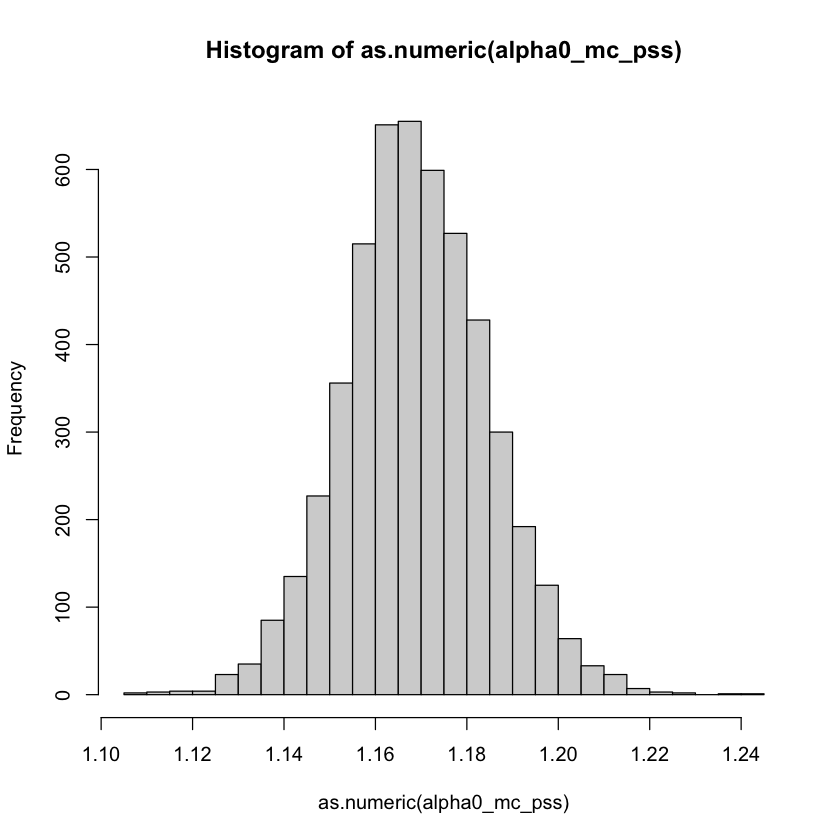

In [38]:
hist(as.numeric(alpha0_mc_pss),breaks=20)

In [39]:
mean(as.numeric(alpha0_mc_pss))

[1] 1.169006

# Monte-Carlo-Simulation of Post-Double-Selection

In [40]:
#We create a list, where we can save all the alpha_0 values retrieved from the Monte-Carlo-Simulation
alpha0_mc_pds<-list() #alpha0 is the coefficient of interest, mc stands for Monte-Carlo and pds for post-double selection

for(j in 1:5000){
    
    
    #We build a sample
    selected_rows_smpl<-sample(nrow(data_frame),30)
    data_frame_smpl<-data_frame[selected_rows_smpl, ]
    
    #We select d to be our depending variable
    regressand_lasso_s1<-data_frame[,2]
    #We select x_1, ..., x_31 to be our regressors. 
    drops <- c("d","y")
    regressors_lasso_s1<-data_frame[, !(names(data_frame) %in% drops)]
    
    #The structure of the penalty indicates, that we do not force LASSO to include certain variables
    penalty_s1<-c(1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)
    
    #We perform LASSO using the minimum value for lambda
    fit_s1<-glmnet(regressors_lasso_s1^2,regressand_lasso_s1, family="gaussian", penalty.factor=penalty_s1)
    lambda_s1<-cv.glmnet(as.matrix(regressors_lasso_s1),as.matrix(regressand_lasso_s1)) #Lambda is found via cross-validation and minimizing the MSPE
    coef(fit_s1,lambda_s1$lambda.min)
    selected_coeffs_s1<-list()
    
    #We have retrieved the information, what covariates to include in a regression (based on step1)
    #We now save them in a list
    
    coef_matrix_s1<-as.matrix(coef(fit_s1,lambda_s1$lambda.min))
    selected_coeffs_s1<-list()
    for (row in 1:nrow(coef_matrix_s1)){
    
        if(coef_matrix_s1[row,1]!=0){
        selected_coeffs_s1[[row]]<-rownames(coef_matrix_s1)[row]
            }
    }   
    
    #Step 2
    
    #We select y as the dependent variable
    regressand_lasso_smpl<-data_frame_smpl[,1]
    #We select d,x_1,..., x_31 as the independet variables
    regressors_lasso_smpl<-data_frame_smpl[,-1]
    
    
    #We create the penalty in a way, that d is always part of the sample
    penalty<-c(0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)
    
    #We perform lasso using a minimum value for lambda
    fit_smpl<-glmnet(regressors_lasso_smpl,regressand_lasso_smpl,family="gaussian",penalty.factor=penalty)
    lambda_smpl<-cv.glmnet(as.matrix(regressors_lasso_smpl),as.matrix(regressand_lasso_smpl))
    coef_matrix_s2<-as.matrix(coef(fit_smpl,lambda_smpl$lambda.min))
    
    #We retrieve the coefficients that matter for predicting y and save them in a list
    
    selected_coeffs<-list()
    for (row in 1:nrow(coef_matrix_s2)){
        if(coef_matrix_s2[row,1]!=0){
        selected_coeffs[[row]]<-rownames(coef_matrix_s2)[row]
        }    
    }
    
    coeffs_s1_s2<-append(selected_coeffs_s1, selected_coeffs)
    
    final_coeffs<-coeffs_s1_s2[!duplicated(coeffs_s1_s2)] #Remove duplicates
    
    tmp_reg_str_smpl<-"regression_post_lasso_smpl<-lm(y ~ d"
for (coefficient in final_coeffs){
    if(all(!is.null(coefficient),!as.character(coefficient)=="(Intercept)",!as.character(coefficient)=="d")){
        tmp_reg_str_smpl<-paste(tmp_reg_str_smpl,"+",coefficient)

    }
    
                                    }
fin_reg_str_smpl<-paste(tmp_reg_str_smpl,",data=data_frame_smpl)")
regression_post_lasso_smpl<-eval(parse(text=fin_reg_str_smpl))
eval(parse(text=gsub(" ","",paste("alpha0_obs",j,"<-regression_post_lasso_smpl$coefficients[2]"))))
eval(parse(text=gsub(" ","",paste("alpha0_mc_pds[[j]]<-alpha0_obs",j))))
}

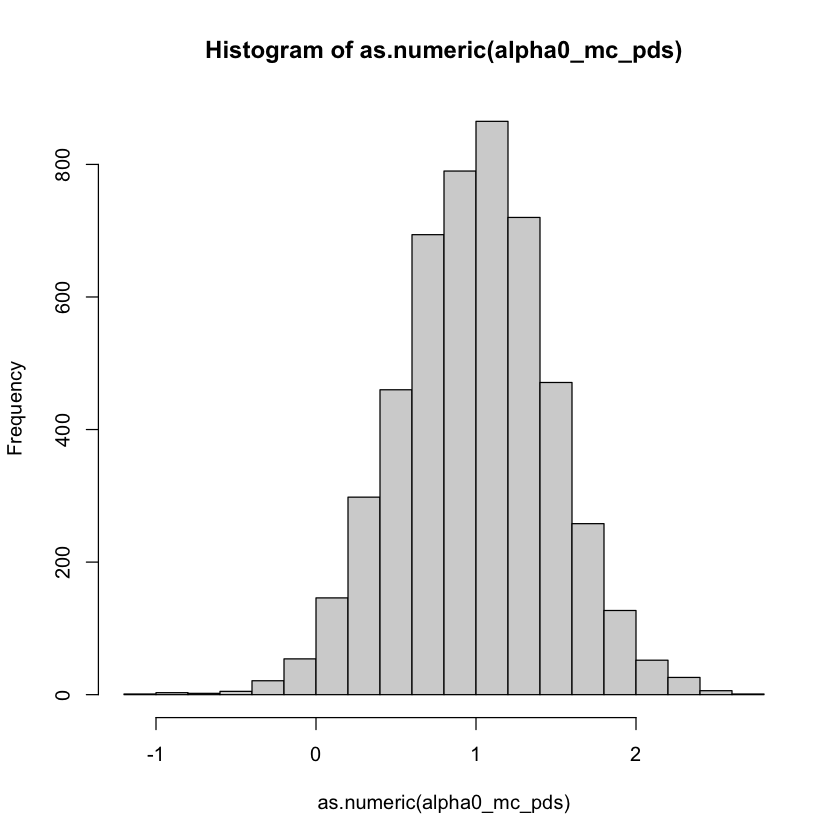

In [41]:
hist(as.numeric(alpha0_mc_pds),breaks=20)

In [42]:
mean(as.numeric(alpha0_mc_pds))

[1] 0.9950065